In [7]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from Cyclist_env_RDA import cyclist_env
from time import time
from scipy.linalg import dft
import torch
import numpy as np
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment
from tqdm import tqdm

In [8]:
# CFAR検出器の実装

def ca_cfar_2d(x_db, n_train=(1,7), n_guard=(1,5), pfa=1e-6, convert_from_db=False):
    """
    x_db: (B,1,H,W) input map (dB or linear)
    n_train: (th, tw) training half window size
    n_guard: (gh, gw) guard half window size
    """
    if convert_from_db:
        x = 10 ** (x_db / 10.0)  # dB -> linear
    else:
        x = x_db

    B, C, H, W = x.shape
    th, tw = n_train
    gh, gw = n_guard

    # Total kernel size
    kh = 2 * (th + gh) + 1
    kw = 2 * (tw + gw) + 1

    # Make training mask
    kernel = torch.ones((1,1,kh,kw), device=x.device)
    kernel[:, :, th-gh:th+gh+1, tw-gw:tw+gw+1] = 0  # guard + CUT = 0

    N_train = kernel.sum().item()
    alpha = N_train * (pfa ** (-1.0 / N_train) - 1.0)

    # Convolution = training sum
    x_pad = F.pad(x, (kw//2, kw//2, kh//2, kh//2), mode="reflect")
    train_sum = F.conv2d(x_pad.double(), kernel.double())
    noise_est = train_sum / N_train

    threshold = alpha * noise_est
    detections = x > threshold
    return detections, threshold, noise_est

# 変更前: tar_thres = -25
# 変更後: tar_thres = -35  (または -30)
def thresholder(radar, idx_est, tar_thres = -25, cyvethres = 2.638):
    cy_idx, ve_idx = [], []
    radar = 20*torch.log10(radar)
    for i in range(len(idx_est)):
        rangeofinterest = radar[:5, max(0, idx_est[i]-5):min(idx_est[i]+5, 589)].flatten()
        top2 = rangeofinterest.topk(2).values.mean()
        if top2 > tar_thres:
            cy_idx.append(idx_est[i])
            ve_idx.append(idx_est[i]) 

    cy_idx_cleans = cleansing(cy_idx)
    ve_idx_cleans = cleansing(ve_idx)

    return cy_idx_cleans, ve_idx_cleans
    
def cleansing(idx, tol = 5):
    if idx :
        res = [idx[0]]
        for i in range(1,len(idx)):
            if idx[i]<=idx[i-1]+5:
                continue
            res.append(idx[i])
        return res
    else: return []

In [9]:
def stevec(N_ant, angle):
    resp = (np.arange(N_ant)-N_ant*0.5+0.5).reshape([-1,1])
    resp = np.exp(1j*resp*np.pi*np.sin(angle))
    return np.matrix(resp)

In [10]:
# csvファイルの読み込み機能を関数化
def syntax_check(num, idx, y_value, velocity_value, x_pos):
    idx_list = np.zeros(num, dtype=np.int32)
    position, velocity = np.zeros((num, 3)), np.zeros((num, 3))
    i=0
    s = set()
    while i < num:
        # 初期値における距離間隔を保証するための処理
        if idx+10 in s or idx-10 in s or idx in s: continue
        for j in range(-20,20): s.add(idx+j)
        
        idx_list[i] = idx
        position[i] = np.array([x_pos[idx], y_value, 1])
        # v_cy[i] = np.array([np.random.rand(1)[0]*5.56, 0, 0])
        velocity[i] = np.array([velocity_value, 0, 0])
        
        i+=1
    return idx_list, position, velocity

def get_snapshot_data(cy_idx_target, ve_idx_target,x_pos, p_bs, tx, cy_v_value, ve_v_value, num_cy, num_ve, num_rp):
    # Cyclistについて
    cy_idx = np.zeros(num_cy, dtype=np.int32)
    p_cy, v_cy = np.zeros((num_cy, 3)), np.zeros((num_cy, 3))
    # 範囲外アクセスを防ぐための処理
    cy_idx, p_cy, v_cy = syntax_check(num_cy, cy_idx_target, 15, cy_v_value, x_pos)
    n_cy = len(p_cy)
    
    # Vehicleについて
    ve_idx = np.zeros(num_ve, dtype=np.int32)
    p_ve, v_ve = np.zeros((num_ve, 3)), np.zeros((num_ve, 3))
    # 範囲外アクセスを防ぐための処理
    ve_idx, p_ve, v_ve = syntax_check(num_ve, ve_idx_target, 7.5, ve_v_value, x_pos)
    n_ve = len(p_ve)

    # ramppostについて
    p_rp, v_rp = np.zeros((num_rp, 3)), np.zeros((num_rp, 3))
    n_rp = len(p_rp)
    
    # csvファイルの読み込み
    cy_idx += 1
    ve_idx += 1

    P_rx_cy, tstemp_rx_cy, phase_cy, P_rx_ve, tstemp_rx_ve, phase_ve, P_rx_rp, tstemp_rx_rp, phase_rp = [], [], [], [], [], [], [], [], []
    for i in range(len(cy_idx)):
        df = pd.read_csv("./ped/0.5nano/complex-impulse-response-Run{:04d}-Sensor_0_Tx_0_to_Rx_0.csv".format(cy_idx[i]))
        tstemp_rx_cy.append(np.ceil((df["Time (s)"]/Tc).values[3:]))
        P_rx_cy.append(df["| Total Complex Impulse Response total | (W)"].values[3:])
        phase_cy.append(df['Phase( Total Complex Impulse Response total ) (rad)'].values[3:])
    for i in range(len(ve_idx)):
        df = pd.read_csv("./vehicle/0.5nano/complex-impulse-response-Run{:04d}-Sensor_0_Tx_0_to_Rx_0.csv".format(ve_idx[i]))
        tstemp_rx_ve.append(np.ceil((df["Time (s)"]/Tc).values[3:]))
        P_rx_ve.append(df["| Total Complex Impulse Response total | (W)"].values[3:])
        phase_ve.append(df['Phase( Total Complex Impulse Response total ) (rad)'].values[3:])
    for i in range(1,4):
        df = pd.read_csv("./Ramposts/"+str(i)+"/complex-impulse-response-Run0001-Sensor_0_Tx_0_to_Rx_0.csv")
        tstemp_rx_rp.append(np.ceil((df["Time (s)"]/Tc).values[5:]))
        P_rx_rp.append(df["| Total Complex Impulse Response total | (W)"].values[5:])
        phase_rp.append(df['Phase( Total Complex Impulse Response total ) (rad)'].values[5:])
        
    phys_quantities = env.phys_quantities(p_bs, p_cy, v_cy, n_cy, p_ve, v_ve, n_ve, p_rp, v_rp, n_rp)
    
    
    ######### We need some functions here. it is like this. read the csv. this outputs the time stemp and corresponding rx value.
    # P_rx_cy_dB = -114
    #P_rx_cy_dB = -111
    #P_rx_ve_dB = -114
    #P_rx_cy_dB = 0
    #P_rx_ve_dB = 0
    
    P_N_dB = -81 # target noise power when using 2GHz BW

    sym_duration = rx_sample*Tc

    Y = env.rx_multiple(tx, P_rx_cy, tstemp_rx_cy, phase_cy, P_rx_ve, tstemp_rx_ve, phase_ve, P_rx_rp, tstemp_rx_rp, phase_rp, P_N_dB, sym_duration, N_trans)
    #print("Cyclelist and Vehicle positions:")
    #print(p_cy)
    #print(p_ve)
    return Y, phys_quantities

#x_pos = list(np.arange(-450, -149)/10)
#p_bs = np.array([250, -18, 50])
#Y, phys_quantities = get_snapshot_data(100,0,x_pos,p_bs)

In [11]:
def MUSIC_method(Y, N_ant):
    Y_music = np.mean(Y, axis=0)
    R_yy = Y_music@np.conjugate(np.transpose(Y_music))
    # print(np.linalg.eig(R_yy)[0])
    U = np.linalg.eig(R_yy)[1][:,5:]

    resp = []
    argm = (np.arange(1800)-900)/100
    for val in argm:
        stv = stevec(N_ant, val*np.pi/180)
        p = stv.T@U
        pp = p*np.conjugate(np.transpose(p))
        resp.append(1/(np.abs(pp)**2).A1)

    M = max(resp)
    est_ang = []
    
    a, b = resp[0][0], resp[1][0]
    for i in range(1,len(argm)-1):
        c = resp[i+1][0]
        if a < b and b > c and b > 0.2 * M:
            est_ang.append(argm[i])
        a, b = b, c
    return est_ang

#angle_list = MUSIC_method(Y)
#print("Estimated angles:", angle_list)

In [36]:
def MUSIC_method_Debug(eig_val, N_ant, num_signals, resp, argm, M):
    """
    MUSIC法の状態を診断するためのデバッグ関数
    """
    print("\n" + "="*30)
    print("【MUSIC法 デバッグ情報】")
    
    # --- 1. 数値情報の出力 ---
    # 固有値の絶対値（大きい順）
    eig_abs = np.abs(eig_val)
    print(f"1. 固有値 (大きい順):\n{eig_abs}")
    
    # 推定された信号数と閾値情報
    print(f"2. 設定信号数 (K): {num_signals}")
    print(f"3. スペクトル最大値 (M): {M:.2e}")
    print(f"4. 現在の閾値 (20%): {0.2 * M:.2e}")

    # --- 2. グラフ描画 (重要) ---
    try:
        """
        # プロットエリアを2つ作成 (左: 固有値分布, 右: MUSICスペクトル)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        
        # === 左のグラフ: 固有値分布 (Scree Plot) ===
        # これを見ることで、信号がノイズから分離できているか確認できます
        ax1.plot(range(1, len(eig_abs) + 1), eig_abs, 'bo-', markersize=8)
        ax1.set_title('Eigenvalue Distribution (Scree Plot)')
        ax1.set_xlabel('Index')
        ax1.set_ylabel('Eigenvalue (log scale)')
        ax1.set_yscale('log') # 固有値は桁が違うことが多いので対数がおすすめ
        ax1.grid(True, which="both", ls="-", alpha=0.5)
        
        # 信号部分とノイズ部分の境界に線を引く
        ax1.axvline(x=num_signals + 0.5, color='r', linestyle='--', label=f'Separation (K={num_signals})')
        ax1.legend()
        
        # === 右のグラフ: MUSICスペクトル ===
        # どこにピークがあり、閾値でどう切られているか確認します
        resp_array = np.array(resp).flatten() # 形状を1次元に統一
        
        ax2.plot(argm, resp_array, label='MUSIC Spectrum')
        ax2.set_title(f'MUSIC Spectrum (N_ant={N_ant}, K={num_signals})')
        ax2.set_xlabel('Angle [deg]')
        ax2.set_ylabel('Spectrum Power')
        ax2.set_yscale('log') # スペクトルも対数で見ると弱いピークが見つけやすい
        ax2.grid(True, which="both", ls="-", alpha=0.5)
        
        # 閾値の線を引く (赤の点線)
        threshold_val = 0.2 * M
        ax2.axhline(y=threshold_val, color='r', linestyle='--', label='Threshold (20%)')
        
        # もし閾値を5%に下げたらどう見えるかも参考として表示 (緑の点線)
        ax2.axhline(y=0.05 * M, color='g', linestyle=':', label='Threshold (5%)')
        
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        print("-> 診断用グラフを描画しました")
        """
        
        # --- ピークのグラフだけ表示 ---
        fig, ax = plt.subplots(figsize=(8, 5))
        resp_array = np.array(resp).flatten() # 形状を1次元に統一
        
        ax.plot(argm, resp_array, label='MUSIC Spectrum')
        ax.set_title(f'MUSIC Spectrum (N_ant={N_ant}, K={num_signals})')
        ax.set_xlabel('Angle [deg]')
        ax.set_ylabel('Spectrum Power')
        ax.set_yscale('log') # スペクトルも対数で見ると弱いピークが見つけやすい
        ax.grid(True, which="both", ls="-", alpha=0.5)
        
        # 閾値の線を引く (赤の点線)
        threshold_val = 0.2 * M
        ax.axhline(y=threshold_val, color='r', linestyle='--', label='Threshold (20%)')
        
        # もし閾値を5%に下げたらどう見えるかも参考として表示 (緑の点線)
        ax.axhline(y=0.05 * M, color='g', linestyle=':', label='Threshold (5%)')
        
        ax.legend()
        
        plt.tight_layout()
        plt.show()
        print("-> 診断用グラフを描画しました")
        
    except Exception as e:
        print(f"-> グラフ描画中にエラーが発生しました: {e}")
        
    print("="*30 + "\n")

In [13]:
def MUSIC_method_improved(Y, N_ant, num_signals):
    Y_music = np.mean(Y, axis=0)
    R_yy = Y_music@np.conjugate(np.transpose(Y_music))
    # 1.固有値分解
    eig_val, eig_vec = np.linalg.eig(R_yy)

    # 2.固有値をソートして雑音部分空間を取得
    idx = np.abs(eig_val).argsort()[::-1]
    # インデックスによって固有値と固有ベクトルの対応関係を維持しつつソート
    eig_val = eig_val[idx]
    eig_vec = eig_vec[:, idx]
    # 雑音部分空間Uを取得

    # num_signalsを固有値から推定?
    
    # デバッグ用
    #num_signals = 1
    
    U = eig_vec[:, num_signals:]

    # 3.雑音部分空間とvalごとのステアリングベクトルの内積を計算
    resp = []
    argm = (np.arange(1800)-900)/100
    for val in argm:
        # ステアリングベクトルの計算
        stv = stevec(N_ant, val*np.pi/180)
        # 雑音部分空間との内積
        p = stv.T@U
        # L2ノルムの二乗を計算(pp^H)
        pp = p*np.conjugate(np.transpose(p))
        # A1は行列を1次元配列に変換するメソッド
        # respに逆数を追加
        # 分子は角度推定の上では不要なので省略している
        resp.append(1/(np.abs(pp)**2).A1)

    # 4.ピーク検出
    M = np.max(resp)
    
    # デバッグ用
    MUSIC_method_Debug(eig_val, N_ant, num_signals, resp, argm, M)
    
    est_ang = []
    # 三点比較によるピーク検出
    a, b = resp[0][0], resp[1][0]
    for i in range(1,len(argm)-1):
        c = resp[i+1][0]
        if a < b and b > c and b > 0.2 * M:
        #if a < b and b > c and b > 0.05 * M:
            est_ang.append(argm[i])
        a, b = b, c
    return est_ang

In [14]:
def Root_MUSIC_method(Y, N_ant, num_signals):
    Y_music = np.mean(Y, axis=0)
    R_yy = Y_music@np.conjugate(np.transpose(Y_music))
    # 1.固有値分解
    eig_val, eig_vec = np.linalg.eig(R_yy)

    # 2.固有値をソートして雑音部分空間を取得
    idx = np.abs(eig_val).argsort()[::-1]
    # インデックスによって固有値と固有ベクトルの対応関係を維持しつつソート
    eig_val = eig_val[idx]
    eig_vec = eig_vec[:, idx]
    # 雑音部分空間Uを取得

    # num_signalsを固有値から推定?
    
    # デバッグ用
    #num_signals = 5
    
    U = eig_vec[:, num_signals:]
    # --- Root-MUSIC 特有の処理 ---
    # 行列 C = U * U^H を計算
    C = U @ U.T.conj()
    
    # 行列Cの対角線の和（係数）を計算
    # 対角線ごとに足し合わせて多項式の係数を作ります
    coeff = np.zeros((2 * N_ant - 1,), dtype=complex)
    for i in range(N_ant):
        for j in range(N_ant):
            coeff[i - j + (N_ant - 1)] += C[i, j]

    # 多項式の根（Roots）を求める
    roots = np.roots(coeff)
    
    # 単位円の内側で、かつ単位円に近い根をK個探す
    # 1. 単位円上の根は振幅が1なので、絶対値が1に近いものを探す
    # 2. 安定性のため単位円の内側(|z| <= 1)の根を選ぶことが多い
    
    # 半径1に近い順にソート（ただしノイズの影響で1を超えることもあるので工夫が必要）
    # 一般的には |z| < 1 の中で |z| が大きい順（円に近い順）にK個選ぶ
    roots = roots[np.abs(roots) <= 1.0] # 単位円内側のみ
    idx = np.argsort(np.abs(roots))[::-1] # 絶対値が大きい順（円に近い順）
    est_roots = roots[idx[:num_signals]] # 上位K個を取得
    
    # 根から角度に変換: z = exp(j * 2pi * d/lambda * sin(theta))
    # arg(z) = 2pi * d/lambda * sin(theta)
    # sin(theta) = arg(z) / (2pi * d/lambda)
    # 通常 d = lambda/2 なので、 sin(theta) = arg(z) / pi
    
    est_ang_rad = np.arcsin(np.angle(est_roots) / np.pi)
    est_ang_deg = np.degrees(est_ang_rad)
    
    return np.sort(est_ang_deg)

In [15]:
p_bs = np.array([250, -18, 50])

def idx_to_xy(range_idx, angle_deg):
    """
    range_idx: cy_idxs_pred の値 (例: 496)
    angle_deg: MUSIC法で推定した角度 [度] (例: est_ang[0])
    """
    offset = 3411
    # (1) 距離の計算 [m]
    # サンプル番号 = インデックス + オフセット
    sample_idx = range_idx + offset
    # 往復時間 = サンプル番号 * Tc
    # 距離 = 往復時間 * c / 2
    R = (sample_idx * Tc * env.c) / 2

    # 三次元距離を二次元距離に変換
    height_diff = p_bs[2] - 1
    if R > height_diff:
        R_horizontal = np.sqrt(R**2 - height_diff**2)
    else:
        R_horizontal = 0

    # (2) 角度の計算 [rad]
    # 推定角度をラジアンに変換し、基準角度(refangle)を足す
    # anglecalの逆演算: cy_ang = arctan(...) - refangle なので
    # arctan(...) = cy_ang + refangle
    theta_world = np.deg2rad(angle_deg) + refangle

    # (3) XY座標の計算 [m]
    # 基地局(p_bs)からの相対位置
    # cy_denum (dx) = R * cos(theta)
    # cy_nu (dy) = R * sin(theta)
    dx = R_horizontal * np.cos(theta_world)
    dy = R_horizontal * np.sin(theta_world)

    # 世界座標（絶対座標）に変換
    # cy_denum = bs[0] - cy[0]  =>  cy[0] = bs[0] - dx
    # cy_nu    = cy[1] - bs[1]  =>  cy[1] = bs[1] + dy
    x = p_bs[0] - dx
    y = p_bs[1] + dy

    return x, y, R

In [16]:
def DFT (N_trans, N_ant, rx_sample, Y, tx, N_sample, est_ang):
    Dopp_dft = dft(N_trans)/np.sqrt(N_trans)
    Y_dft = np.zeros((N_trans, N_ant, rx_sample), dtype=np.complex128)
    for i in range(N_ant):
        Y_dft[:,i,:] = Dopp_dft@Y[:,i,:]
    val, res, rdresp = 0, [], np.zeros((N_trans,590), dtype=np.complex128)
    Q = 1

    # 結果を保存するリスト
    detected_objects = []
    
    # レンジドップラーマップ用のリスト
    rd_maps = []
    
    P_range = np.arange(590)+3411
    #P_range = np.arange(150) + 3800
    
    for i in range(len(est_ang)):
        current_angle = est_ang[i]
        #  他の角度の結果と混ざらないように rdresp_single を使う
        rdresp_single = np.zeros((N_trans, 590), dtype=np.complex128)
        ang_rad = current_angle * np.pi / 180
        dup = np.ones((N_trans, 1, 1), dtype=np.complex128)
        
        for p in P_range: # レンジ方向のループ
            # ... (既存の信号生成・相関処理 tx, stevec など) ...
            X_cand = np.zeros((N_ant, rx_sample), dtype=np.complex128)
            last = min(p+N_sample, rx_sample)
            X_cand[:,p:last] += tx[:,:last-p]
            g = np.conjugate(stevec(N_ant, ang_rad))@np.conjugate(np.transpose(stevec(N_ant, ang_rad)))@X_cand
            g_mat = dup*np.array(g)
            metric = np.sum(np.multiply(np.conjugate(Y_dft), g_mat), axis=(1,2))
            
            # ここで rdresp ではなく rdresp_single に保存
            rdresp_single[:, p-3411] = metric
            
        # 【追加】完成したマップをリストに保存 (コピーして保存)
        rd_maps.append((rdresp_single.copy(),i))
            
        # CFAR検出器の利用
        radar_in = torch.tensor(abs(rdresp_single)).unsqueeze(0).unsqueeze(0)
        detections, _, _ = ca_cfar_2d(radar_in, convert_from_db=False)
        idx_est = torch.nonzero(detections[0,0,0], as_tuple=True)[0].tolist()
        current_range_idxs, _ = thresholder(radar_in[0,0], idx_est)
        
        print("検出した距離：", current_range_idxs)
        
        # 座標変換と結果保存
        if len(current_range_idxs) > 0:
            print(f"角度 {current_angle:.2f} 度 のマップからの検出:")
            for r_idx in current_range_idxs:
                x_est, y_est, r_est = idx_to_xy(r_idx, current_angle)
                detected_objects.append([r_est, current_angle ,x_est, y_est])
                print(f"  -> Index: {r_idx}, Range: {r_est:.2f}m, X: {x_est:.2f}m, Y: {y_est:.2f}m")
        else:
            print(f"ターゲット不検出")
    return detected_objects, rd_maps

#Y, phys_quantities = get_snapshot_data(100,0)
#est_ang = MUSIC_method(Y)
#detected_objects = DFT(N_trans, N_ant, rx_sample, Y, tx, N_sample, est_ang)
#print("Detected objects (X, Y):", detected_objects)

In [22]:
def RD_MAP(rd_maps, save_dir="./rd_maps/"):
    # ディレクトリがなければ作成
    os.makedirs(save_dir, exist_ok=True)
    
    output = rd_maps[0][:100,:] + 1e-10
    i=9
    plt.imshow(20*np.log10(abs(output)), vmin = -30)
    # 変更点？
    plt.ylim(0,5)
    plt.xlim(0 + 50*i,50 + 50*i)
    plt.colorbar()
    plt.show()
    i+=1
    plt.imshow(20*np.log10(abs(output)), vmin = -30)
    # 変更点？
    plt.ylim(0,5)
    plt.xlim(0 + 50*i,50 + 50*i)
    # plt.colorbar()
    plt.show()

Debug

【MUSIC法 デバッグ情報】
1. 固有値 (大きい順):
[1.06047655e-08 5.31743685e-10 5.25996309e-10 5.23058931e-10
 5.17568866e-10 5.10126397e-10 5.01653335e-10 4.98799596e-10
 4.95031988e-10 4.87549838e-10 4.82942194e-10 4.79138898e-10
 4.72159522e-10 4.68692426e-10 4.65548427e-10 4.57257752e-10]
2. 設定信号数 (K): 1
3. スペクトル最大値 (M): 2.15e+05
4. 現在の閾値 (20%): 4.29e+04


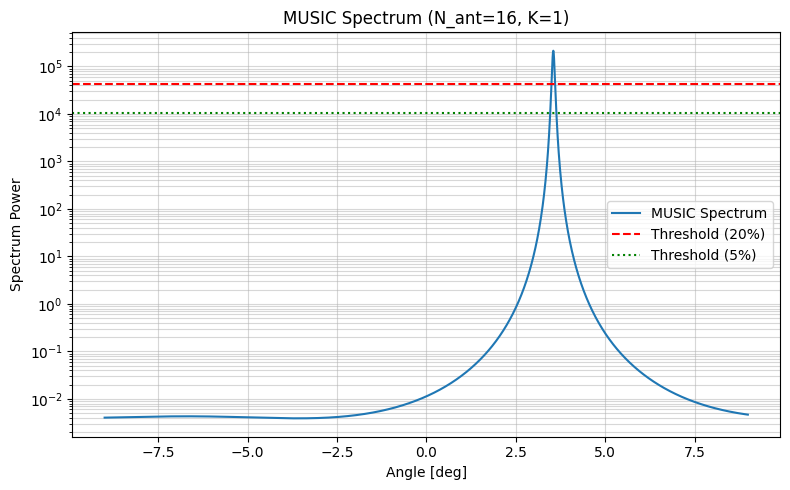

-> 診断用グラフを描画しました

[np.float64(3.55)]

Data generation complete.
Saved 'measurements.csv'.


: 

In [ ]:
###### symbol time & carrier frequency ######
T_symbol = 1.115 * 1e-6              # symbol duration, with CP time
T_OFDM = 1.0425 * 1e-6
f_carrier = 28 * 1e+9
Tc = 0.509*1e-9                      # sampling time

###### tx/rx ######
N_ant = 16                       # the number of antennas
BW = 1.966080e+9                      # chirp bandwidth
BW_sub = BW/N_ant
N_sample = int(np.floor(T_symbol/Tc))           # the number of samples of single chirp
offset = 4000
rx_sample = offset + N_sample



###### Radar setting ######

N_chirp = 100                    # the number of chirps
mu = BW_sub/T_symbol * 0.98
Q = 30
Phi = 0.3*np.pi

l_speed = 299792458

N_trans = 100

refangle = np.arctan(33/265)/2 # 基準角度の設定(cyclist_env_RDA.pyより)


env = cyclist_env(f_carrier, N_ant, BW, BW_sub, N_sample, rx_sample, Tc, mu, l_speed)
tx = env.tx()

# シミュレーション設定
num_cy = 1
num_ve = 0
num_rp = 0

start_cy_idx = 300
start_ve_idx = 3
#start_cy_idx = 75
#start_ve_idx = 50

end_cy_idx = 300
end_ve_idx = 3
#end_cy_idx = 135
#end_ve_idx = 150

cy_interval = 2
ve_interval = 5

cy_v_value = 6
ve_v_value = 10

cy_idx = start_cy_idx
ve_idx = start_ve_idx

measurement_history = []
frame_count = 0

# 繰り返し処理
while cy_idx <= end_cy_idx and ve_idx <= end_ve_idx:
    print("Debug")
    x_pos = list(np.arange(-450, -149)/10)
    p_bs = np.array([250, -18, 50])
    Y, phys_quantities = get_snapshot_data(cy_idx,ve_idx,x_pos,p_bs, tx, cy_v_value, ve_v_value, num_cy, num_ve, num_rp)
    #est_ang = MUSIC_method(Y, N_ant)
    est_ang = MUSIC_method_improved(Y, N_ant, num_cy + num_ve + num_rp)
    #est_ang = Root_MUSIC_method(Y, N_ant, num_cy + num_ve + num_rp)
    print(est_ang)
    """
    detected_objects, rd_maps = DFT(N_trans, N_ant, rx_sample, Y, tx, N_sample, est_ang)
    print("Detected objects (X, Y):", detected_objects)
    #RD_MAP(rd_maps, save_dir="./rd_maps")
    
    if len(detected_objects) > 0:
        for obj in detected_objects:
            measurement_history.append({
                "Time": frame_count,  # 時刻（フレーム番号）
                "Range": obj[0],      # 距離 [m]
                "Angle": obj[1],      # 角度 [度]
                "X": obj[2],          # X座標 [m]
                "Y": obj[3]           # Y座標 [m]
            })
    else:
        # 何も検出されなかった場合も、時刻だけ記録したい場合は以下のようにNaNを入れる
        # (不要であればこのelseブロックは削除してください)
        measurement_history.append({
            "Time": frame_count,
            "Range": np.nan,
            "Angle": np.nan,
            "X": np.nan,
            "Y": np.nan
        })
    """
    cy_idx += cy_interval
    ve_idx += ve_interval
    frame_count += 1
    
# csvファイルに保存
# --- 6. CSVへの保存 ---
df_measurements = pd.DataFrame(measurement_history)

# 保存
csv_filename = "measurements.csv"
df_measurements.to_csv(csv_filename, index=False)

print("\nData generation complete.")
print(f"Saved '{csv_filename}'.")
